<a href="https://colab.research.google.com/github/alenzhasulan/dl-nlp/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import numpy as np
import re
import collections

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Загружаем данные
JSONFile = open('data.json')
data = json.loads(JSONFile.read())
JSONFile.close()


train_source=data

In [0]:
TOKEN_RE=re.compile(r'[\w\d]+')

#Возвращает для каждого строку 
def tokenize_text_regex(txt,min_token_size=3):
  txt=txt.lower()
  all_tokens=TOKEN_RE.findall(txt)
  return [token for token in all_tokens if len(token)>=min_token_size]

#Для токенезаций
def tokenize_corpus(texts,tokenizer=tokenize_text_regex,**tokenizer_kwargs):
  return [tokenizer(text,**tokenizer_kwargs) for text in texts]

In [0]:
tokinezed_corpus=tokenize_corpus(train_source)

In [0]:
def build_vocabulary(tokenized_texts,max_size=10000000,max_doc_freq=0.8,min_count=5,pad_word=None):
  word_counts=collections.defaultdict(int)
  doc_n=0

  # подсчитать количество документов, в которых употребляется слова каждое слово
  # а также общее количество документов
  for txt in tokenized_texts:
    doc_n+=1
    unique_text_tokens=set(txt)
    for token in unique_text_tokens:
      word_counts[token]+=1
  
  # убрать слишком редкие и слишком частые слова
  word_counts={word:cnt for word,cnt in word_counts.items() if cnt>=min_count and cnt/doc_n<=max_doc_freq}

  # отсортировать слова по убыванию частоте 
  sorted_word_counts=sorted(word_counts.items(),reverse=True,key=lambda pair:pair[1])

  #добавим несуществующие слова с индексом 0 для удобство пакетной отроботки
  if pad_word is not None:
    sorted_word_counts=[(pad_word,0)]+sorted_word_counts

  #если у нас много слов от оставить самых частотных
  if len(word_counts)>max_size:
    sorted_word_counts=sorted_word_counts[:max_size]

  #нумируем слова
  word2id={word:i for i ,(word,_) in enumerate(sorted_word_counts)}

  #нормируем частотных слов
  word2freq=np.array([cnt/doc_n for _,cnt in sorted_word_counts],dtype='float32')

  return word2id,word2freq
  


In [145]:
MAX_DF=0.8
MIN_COUNT=5

vocabulary, word_doc_freq=build_vocabulary(tokinezed_corpus,
                                           max_doc_freq=MAX_DF,
                                           min_count=3,
                                           pad_word='<PAD>'
                                           )
UNIQUE_WORDS_N=len(vocabulary)
# print('Количество уникальных токенов ',UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

[('<PAD>', 0), ('алтын', 1), ('батыс', 2), ('орда', 3), ('алғашқы', 4), ('болған', 5), ('түрік', 6), ('хан', 7), ('қазақ', 8), ('орданың', 9)]


In [0]:
def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]

In [0]:
#отображаем номера в токене
train_token_ids=texts_to_token_ids(tokinezed_corpus,vocabulary)

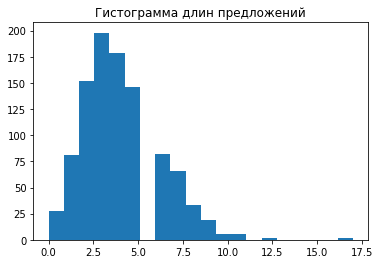

In [163]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [0]:
def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt
    
#Создаем тензор и выровниваем 
class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target

In [169]:
MAX_SENTENCE_LEN = 18
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
print(train_dataset[10])

(tensor([122, 194, 367,  56,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]), tensor(0))
